# Inclinación del arbolado público en Mendoza

## Motivación

El siguiente desafío surge como propuesta dentro de la Cátedra de Aprendizaje de Maquinas(AM) de la Universidad Tecnológica Nacional Facultad Regional Mendoza, el laboratorio DHARMA y el LABSIN de la Universidad Nacional de Cuyo.

El objetivo detras del presente desafio es el de predecir aquellos especimenes que tengan un grado de inclinación peligroso (i.e. mayor a 30 grados) a partir de sus caracteristcas biologicas e información geografica/administrativa. Para tal fin se cuenta con un conjunto de datos que contiene el censo georeferenciado del arbolado publico en la ciudad de Mendoza al año 2012. 

###### Dado el alto nivel de desbalanceo de las clases, para esta competencia vamos a usar la métrica conocida como ROC (Area Under de Curve).

# Librerias

In [181]:
#Manejo de datos
import pandas as pd
import numpy as np

#Graficos
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap

#Preprocesado, metricas y modelos
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Dataset

In [6]:
train=pd.read_csv("arbolado-mza-dataset.csv")
test=pd.read_csv("arbolado-mza-dataset-test.csv")
features=pd.read_csv("arbolado-mza-dataset-descripcion.csv")

In [7]:
features

,atributo,tipo,descripcion
0,id,integer,Identificacion
1,especie,integer,Especie del Forestal del Forestal
2,ultima_modificacion,character,Fecha de la ultima modificacion del registro
3,altura,integer,Altura del Forestal
4,circ_tronco_cm,double,Circunferencia del Tronco del Forestal
5,diametro_tronco,integer,Diametro del Tronco del Forestal
6,long,double,Longitud (Posicion Geografica)
7,lat,double,Latitud (Posicion Geografica)
8,seccion,integer,Numero de Seccion Administrativa a la que pert...
9,nombre_seccion,character,Nombre de la Seccion Administrativa


In [8]:
train.shape, test.shape

((31912, 12), (13676, 11))

In [9]:
submission=pd.DataFrame()
submission["id"]=test["id"]

# 1. Análisis exploratorio de datos

## 1.1 Variables categóricas

### 1.1 especie

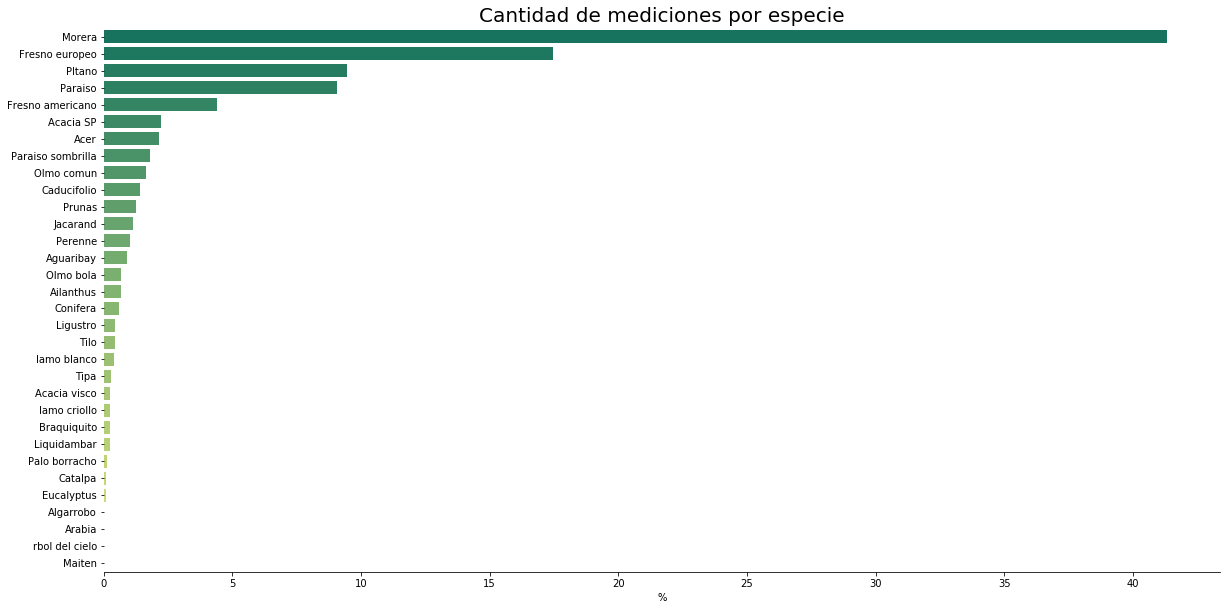

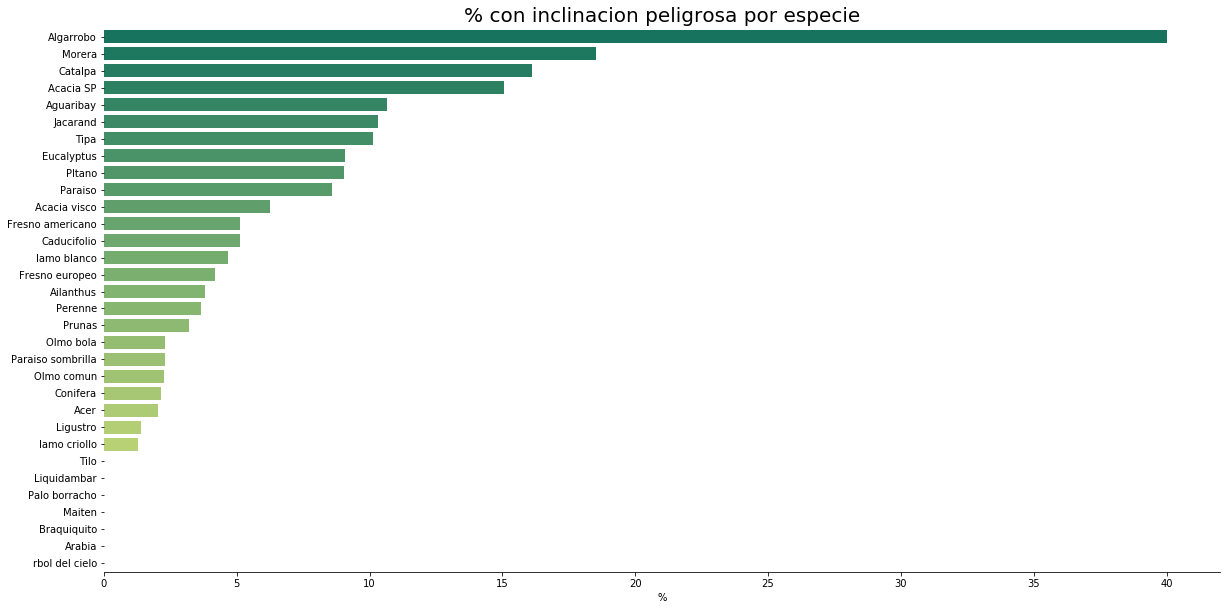

In [10]:
especies=(train["especie"].value_counts()/len(train)*100).reset_index(name="%")

especie_pct=(train.groupby("especie")["inclinacion_peligrosa"].sum()/train.groupby("especie")["inclinacion_peligrosa"].count()*100).reset_index(name="%")
especie_pct=especie_pct.sort_values(by="%",ascending=False)

plt.figure(figsize=(20,10))
sns.barplot(especies["%"],especies["index"],palette="summer")
sns.despine(top=True,right=True,left=True,bottom=False)
plt.ylabel(None)
plt.title("Cantidad de mediciones por especie", fontsize=20)
plt.show()


plt.figure(figsize=(20,10))
sns.barplot(especie_pct["%"],especie_pct["especie"],palette="summer")
sns.despine(top=True,right=True,left=True,bottom=False)
plt.ylabel(None)
plt.title("% con inclinacion peligrosa por especie", fontsize=20)
plt.show()

- Las especies mas muestreadas son: Morera, fresno europeo y americano, platano y paraiso
- El 40% de los algarrobos presento inclinacion peligrosa
- Morera,catalpa y acacia SP entre el 15% - 20% con inclinacion peligrosa

### 1.1.2 ultima_modificacion

In [11]:
train["ultima_modificacion"]=pd.to_datetime(train["ultima_modificacion"])
test["ultima_modificacion"]=pd.to_datetime(test["ultima_modificacion"])

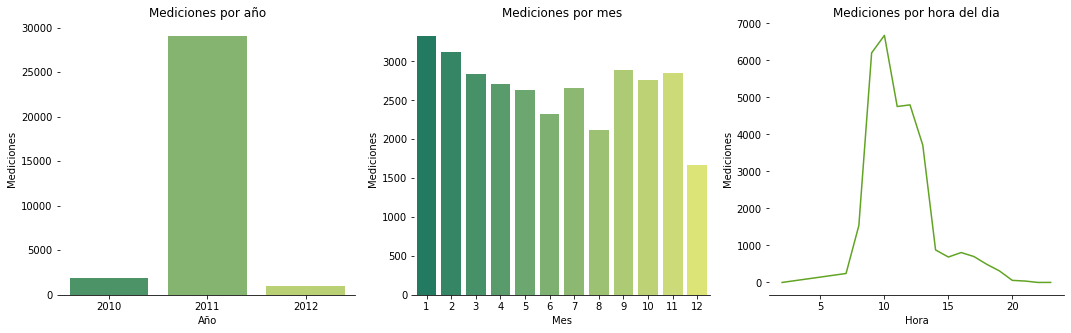

In [12]:
years=train["ultima_modificacion"].dt.year.value_counts().reset_index(name="Mediciones")
month=train["ultima_modificacion"].dt.month.value_counts().reset_index(name="Mediciones")
hours=train["ultima_modificacion"].dt.hour.value_counts().reset_index(name="Mediciones")

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(18,5))

sns.barplot(years["index"],years["Mediciones"],palette="summer", ax=ax1)
sns.barplot(month["index"],month["Mediciones"],palette="summer", ax=ax2)
sns.lineplot(hours["index"],hours["Mediciones"],color="#61a323",ax=ax3)
sns.despine(top=True,right=True,left=True,bottom=False)

ax1.title.set_text("Mediciones por año")
ax2.title.set_text("Mediciones por mes")
ax3.title.set_text("Mediciones por hora del dia")

ax1.set_xlabel("Año")
ax2.set_xlabel("Mes")
ax3.set_xlabel("Hora")

plt.show()

- Las mediciones se realizaron a partir del fin de año del 2010 hasta principios del 2012
- El horario de medicion fue en la mañana (8hs - 14hs)

### 1.1.3 altura

In [13]:
alt_dicc={"Medio (4 - 8 mts)":"Medio", "Bajo (2 - 4 mts)":"Bajo", 
          "Alto (> 8 mts)":"Alto", "Muy bajo (1 - 2 mts)":"Muy bajo"}

train["altura"]=train["altura"].map(alt_dicc)
test["altura"]=test["altura"].map(alt_dicc)

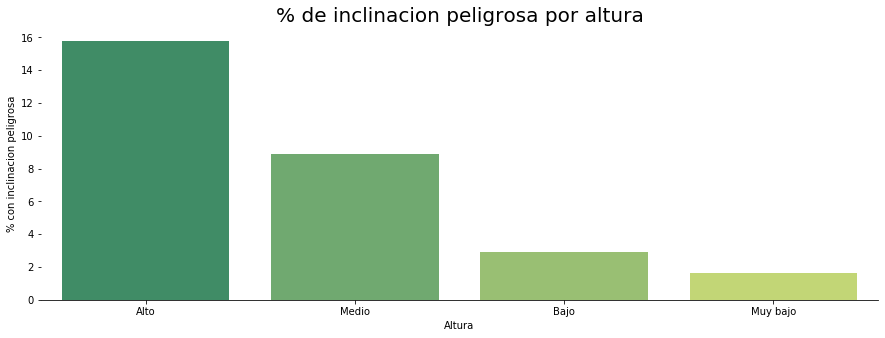

In [14]:
altura=train["altura"].value_counts().reset_index(name="Mediciones")
altura["inclinacion peligrosa"]=train[train["inclinacion_peligrosa"]==1]["altura"].value_counts().values
altura["pct"]=altura["inclinacion peligrosa"]/altura["Mediciones"]*100

plt.figure(figsize=(15,5))
sns.barplot(altura["index"],altura["pct"],palette="summer")
sns.despine(top=True,right=True,left=True,bottom=False)
plt.ylabel("% con inclinacion peligrosa")
plt.xlabel("Altura")
plt.title("% de inclinacion peligrosa por altura", fontsize=20)
plt.show()

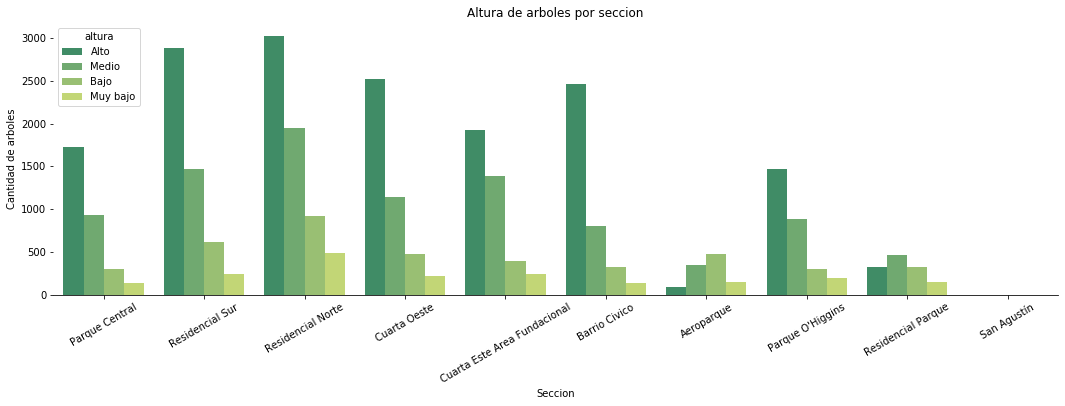

In [156]:
plt.figure(figsize=(18,5))
sns.countplot(train["nombre_seccion"],hue=train["altura"],
              hue_order=["Alto","Medio","Bajo","Muy bajo"],palette="summer")
plt.xticks(rotation=30)
sns.despine(top=True,right=True,left=True,bottom=False)
plt.ylabel("Cantidad de arboles")
plt.xlabel("Seccion")
plt.title("Altura de arboles por seccion", fontsize=12)
plt.show()

### 1.1.4 diametro_tronco

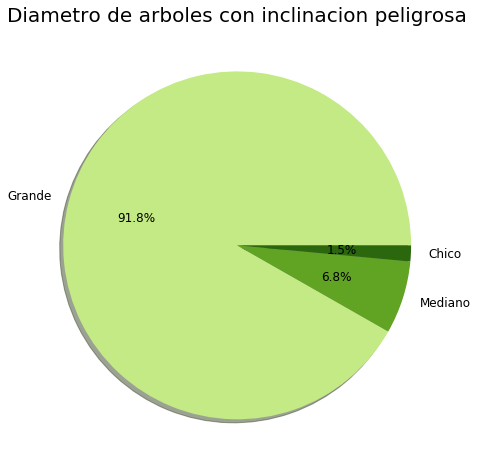

In [16]:
plt.figure(figsize=(8,8))

plt.pie(train[train["inclinacion_peligrosa"]==1]["diametro_tronco"].value_counts(),
        labels=["Grande","Mediano","Chico"], autopct='%1.1f%%',shadow=True, 
        colors=["#c3ea84","#61a323","#2b680d"], textprops={"fontsize":"12"})
plt.title("Diametro de arboles con inclinacion peligrosa", fontsize=20)
plt.show()

### 1.1.5 nombre_seccion - area_seccion - seccion

In [17]:
train["nombre_seccion"]=np.where(train["nombre_seccion"]=="Cuarta Este Á\x81rea Fundacional",
                                 "Cuarta Este Area Fundacional",train["nombre_seccion"])

test["nombre_seccion"]=np.where(test["nombre_seccion"]=="Cuarta Este Á\x81rea Fundacional",
                                 "Cuarta Este Area Fundacional",test["nombre_seccion"])

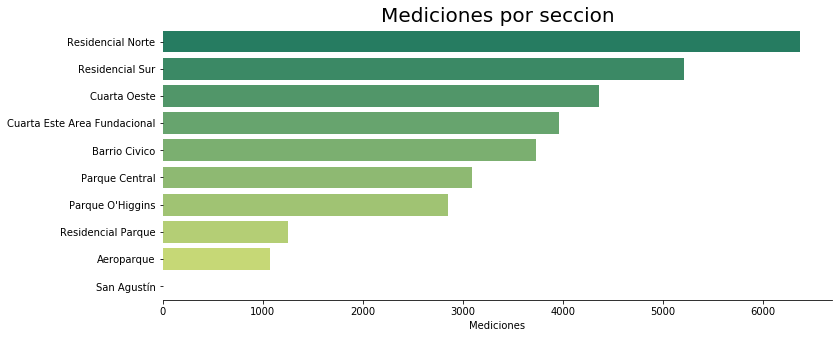

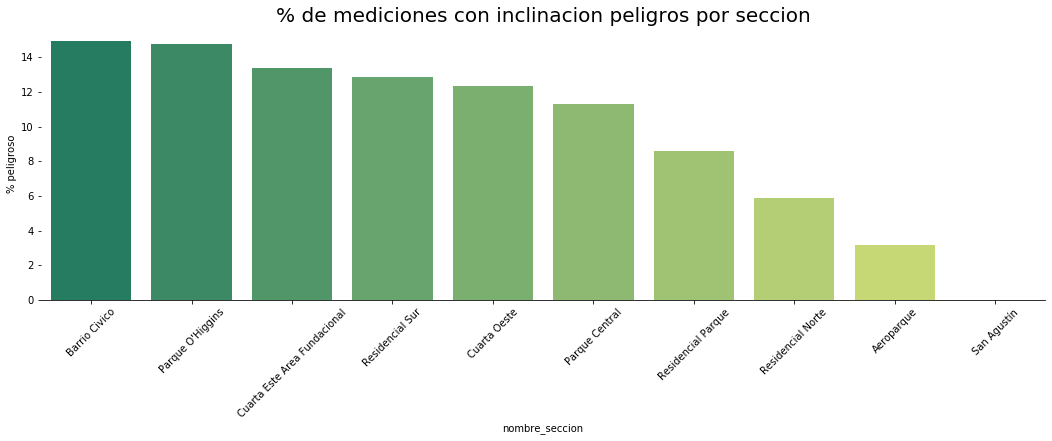

In [18]:
seccion=train["nombre_seccion"].value_counts().reset_index(name="Mediciones")

plt.figure(figsize=(12,5))
sns.barplot(seccion["Mediciones"],seccion["index"],palette="summer")
sns.despine(top=True,right=True,left=True,bottom=False)
plt.ylabel(None)
plt.title("Mediciones por seccion", fontsize=20)
plt.show()



seccion_pct=(train.groupby("nombre_seccion")["inclinacion_peligrosa"].sum()/train.groupby("nombre_seccion")["inclinacion_peligrosa"].count()*100).reset_index(name="% peligroso")
seccion_pct=seccion_pct.sort_values(by="% peligroso",ascending=False)

plt.figure(figsize=(18,5))
sns.barplot(seccion_pct["nombre_seccion"],seccion_pct["% peligroso"],palette="summer")
plt.title("% de mediciones con inclinacion peligros por seccion", fontsize=20)
sns.despine(top=True,right=True,left=True,bottom=False)
plt.xticks(rotation=45)
plt.show()

In [19]:
(train["seccion"].astype(str)+" "+train["nombre_seccion"].astype(str)+" "+train["area_seccion"].astype(str)).unique()

array(['1 Parque Central 1655357.93265',
       '5 Residencial Sur 2423808.92355',
       '6 Residencial Norte 2694682.37982',
       '4 Cuarta Oeste 1173332.70145',
       '4 Cuarta Este Area Fundacional 1822015.85685',
       '2 Barrio Civico 2366816.36021', '8 Aeroparque 2203364.73622',
       "3 Parque O'Higgins 1531146.02653",
       '7 Residencial Parque 1786336.0896599998',
       '11 San Agustín 6853531.2016900005'], dtype=object)

## 1.2 Variables numéricas

### 1.2.1 circ_tronco_cm

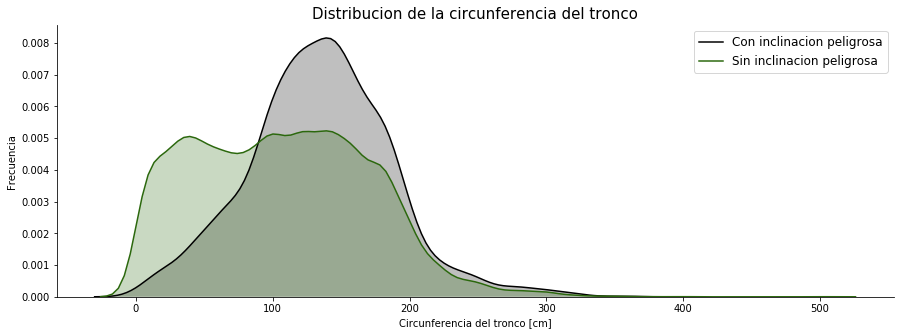

In [20]:
plt.figure(figsize=(15,5))

sns.kdeplot(train[train["inclinacion_peligrosa"]==1]["circ_tronco_cm"],color="k", label="Con inclinacion peligrosa",shade=True)
sns.kdeplot(train[train["inclinacion_peligrosa"]==0]["circ_tronco_cm"],color="#2b680d", label="Sin inclinacion peligrosa",shade=True)
plt.title("Distribucion de la circunferencia del tronco", fontsize=15)
sns.despine(top=True,right=True,left=False,bottom=False)
plt.legend(fontsize=12)
plt.xlabel("Circunferencia del tronco [cm]")
plt.ylabel("Frecuencia")
plt.show()

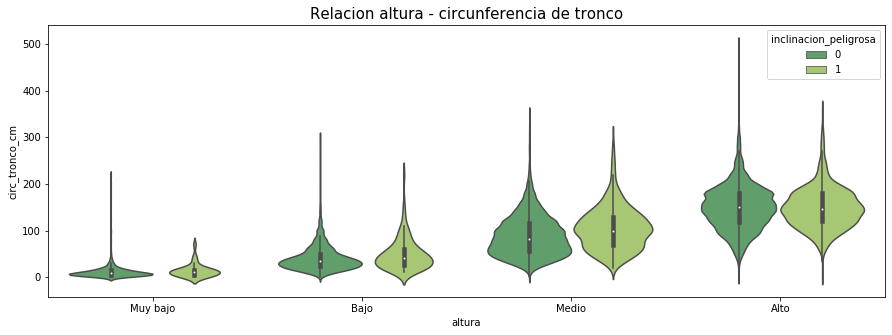

In [21]:
plt.figure(figsize=(15,5))
sns.violinplot(train["altura"],train["circ_tronco_cm"],palette="summer", 
               order=["Muy bajo","Bajo","Medio","Alto"], hue=train["inclinacion_peligrosa"])
plt.title("Relacion altura - circunferencia de tronco", fontsize=15)
plt.show()

## 1.3 Variables geo

### 1.3.1 Mapa de calor de mediciones

In [22]:
mapa = folium.Map(location=[-32.8895, -68.8458],
                        tiles = "Stamen Toner",
                        zoom_start = 15)

HeatMap(train[["lat","long"]],radius=9).add_to(mapa)
mapa

### 1.3.2 Secciones de mediciones

In [23]:
mapa2 = folium.Map(location=[-32.8895, -68.8458],
                        tiles = "Stamen Toner",
                        zoom_start = 13)

for seccion in train["nombre_seccion"].unique():
    folium.Circle(location=train[train["nombre_seccion"]==seccion][["lat","long"]].mean(), radius=750,
                    line_color='#3186cc',
                    fill_color='#3186cc',
                      popup=seccion).add_to(mapa2)

mapa2

# 2. Preprocessing 

#### SELECCION DE VARIABLES 
- Idea variable --> inclinacion peligrosa/area seccion

In [50]:
cat_cols=["especie","altura","diametro_tronco","nombre_seccion"]
num_cols=["circ_tronco_cm","long","lat"]

In [117]:
test_pro=test[cat_cols+num_cols]
X=train[cat_cols+num_cols]
Y=train["inclinacion_peligrosa"]

## 2.1 One hot encoding

In [118]:
concat=pd.concat([X,test_pro])
concat=pd.get_dummies(concat,columns=cat_cols)
X=concat.iloc[:len(train),:]
test_pro=concat.iloc[len(train):,:]

## 2.2 Scaler

In [119]:
scaler=StandardScaler().fit(X[num_cols])

In [120]:
x_scaled=scaler.transform(X[num_cols])
test_scaled=scaler.transform(test_pro[num_cols])

In [143]:
test_pro.loc[:,num_cols]=test_scaled
X.loc[:,num_cols]=x_scaled

### 2.3 Train/Test split

In [147]:
X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

In [153]:
Y_train.value_counts()

0    22689
1     2840
Name: inclinacion_peligrosa, dtype: int64

In [155]:
Y_test.value_counts()

0    5644
1     739
Name: inclinacion_peligrosa, dtype: int64

**- Será necesario realizar un balanceo de los datos para entrenar al modelo, ya que la clase con inclinación peligrosa está presente un 13% en el dataset. Esto puede llevar a crear un modelo que solo prediga la clase mayoritaria.**


**- Primero hay que entrenar el modelo con un dataset usando under/over sampling, luego testearlo en el conjunto de testing original.**
- Nunca testear el modelo en un dataset under/oversampled
- Si se implementa CV, hay que realizar el under/oversampled durante el CV, no antes.

# 3. Modelo

##  3.1 Sin under/over sampling / AUC Baseline

In [198]:
forest=RandomForestClassifier(n_jobs=-1)
forest.fit(X_train,Y_train)
pred=forest.predict(X_test)
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      5644
           1       0.37      0.12      0.18       739

    accuracy                           0.87      6383
   macro avg       0.63      0.55      0.56      6383
weighted avg       0.83      0.87      0.85      6383



In [223]:
cross_val_score(forest,X_train,Y_train,cv=5,scoring="roc_auc")

array([0.74190502, 0.74181423, 0.76026989, 0.75191788, 0.73642015])

In [199]:
print("AUC = {}".format(roc_auc_score(Y_test,pred)))

AUC = 0.5470166505391143


Como se puede observar, el accuracy del modelo es bastante bueno, pero el recall es solo 12% con un 54.7% de AUC

Esto es debido al gran desbalanceo que existe. Por lo tanto, se descarta la posibilidad de entrenar un modelo con los datos desbalanceados

## 3.2 SMOTE (oversampling)

#### SMOTE = Synthetic Minority Over-sampling Technique.

Esta técnica, crea data points sinteticos (nuevos) para balancear las clases. Crea tantos puntos de la clase minotaria como sea necesario para poder tener la misma cantidad de data points de todas las clases.

Toma la distancia entre los vecinos mas cercanos de la clase minoritaria y entre medio de estos crea estos puntos sintéticos. 

### 3.2.1 CV wrong way

In [218]:
oversampler = SMOTE()
wrong_x, wrong_y = oversampler.fit_resample(X_train,Y_train)
model=RandomForestClassifier()
%time cross_val_score(model,wrong_x,wrong_y,cv=5,scoring="roc_auc")

CPU times: user 40 s, sys: 192 ms, total: 40.2 s
Wall time: 40.2 s


array([0.92694962, 0.95637337, 0.96004396, 0.95517392, 0.95660772])

### 3.2.2 CV right way

In [219]:
imba_pipeline = Pipeline([('oversampler', oversampler), ('model', model)])
%time cross_val_score(imba_pipeline,X_train,Y_train,cv=5,scoring="roc_auc")

CPU times: user 39.9 s, sys: 99.7 ms, total: 40 s
Wall time: 40 s


array([0.72870913, 0.7365244 , 0.75815531, 0.74367159, 0.72502499])

In [220]:
model.fit(wrong_x,wrong_y)
pred=model.predict(X_test)
roc_auc_score(Y_test,pred)

0.620514654334923

El AUC del modelo creado con la técnica de SMOTE es mayor frente al creado sin oversampling. Pero si primero se hace el oversampling y luego CV, no va a ser representativo el CV-score, por lo tanto debemos hacerlo durante.
Esto se puede lograr con la ayuda de ```Pipeline``` de la libreria imblearn.
- ***Fuente***: https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html

### 3.2.3 Hiperparametros

In [222]:
model=RandomForestClassifier()

imba_pipeline = Pipeline([
        ('oversampler', oversampler),
        ('model', model)])

params = {"model__min_samples_leaf":[2,3,4],
          "model__max_features":["sqrt",0.5,"log2"],
          "model__n_estimators":[50,100,130]}

grid = GridSearchCV(imba_pipeline, params, scoring="roc_auc", cv=5)
%time grid.fit(X_train, Y_train)

CPU times: user 18min 43s, sys: 1.97 s, total: 18min 45s
Wall time: 18min 45s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('oversampler',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=None,
                                              sampling_strategy='auto')),
                                       ('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                   

In [224]:
grid.best_params_

{'model__max_features': 'log2',
 'model__min_samples_leaf': 4,
 'model__n_estimators': 130}

In [225]:
grid.best_score_

0.7657974020171862

In [298]:
forest_tuned=RandomForestClassifier(max_features="log2",min_samples_leaf=6,n_estimators=150,oob_score=True)
forest_tuned.fit(wrong_x,wrong_y)
pred=forest_tuned.predict(X_test)
print("AUX test = {}".format(roc_auc_score(Y_test,pred)))

AUX test = 0.6819528372184911


In [242]:
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.94      0.77      0.85      5644
           1       0.25      0.59      0.35       739

    accuracy                           0.75      6383
   macro avg       0.59      0.68      0.60      6383
weighted avg       0.86      0.75      0.79      6383



El AUC en el test set aumentó un 6% con estos nuevos hiperparametros

### 3.2.4 Interpretación del modelo

In [243]:
def importances_plot(X,model):
    
    feature_imp=pd.DataFrame(list(zip(X.columns,model.feature_importances_))).sort_values(by=1,ascending=False)
    plt.figure(figsize=(15,8))
    sns.barplot(feature_imp[1],feature_imp[0],palette="RdYlGn_r",orient="h")
    plt.xticks(rotation=90)
    plt.title("Importancia de variables", fontsize=12)
    plt.xlabel("Importancia %")
    plt.ylabel("Variables")
    plt.show()

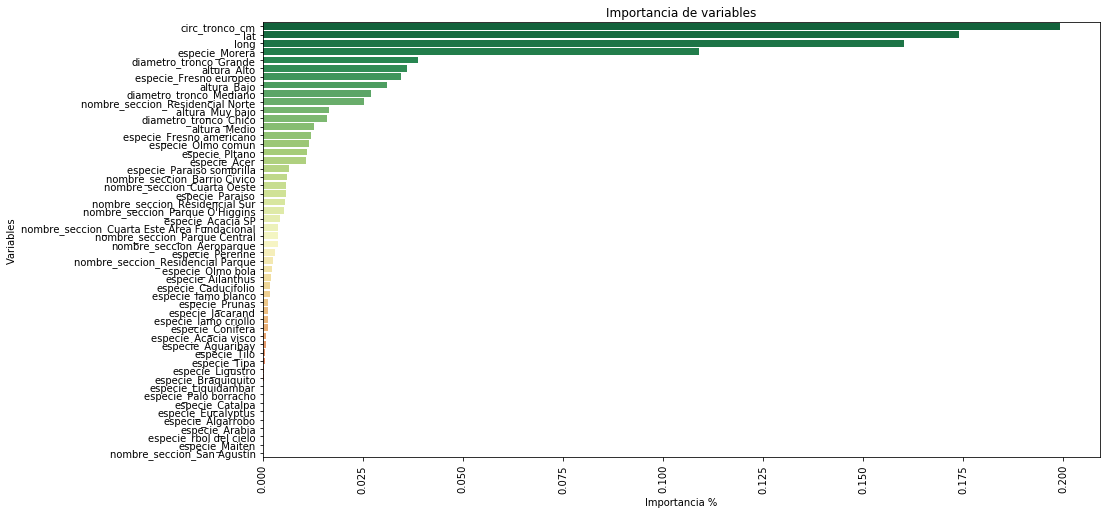

In [244]:
importances_plot(X_train,forest_tuned)

#### Este gráfico nos muestra que tan importante son nuestras variables para el modelo.
Calculo de feature importance:

    1 - Con el modelo creado, se calcula su score.
    2 - Mezcla los valores de la variable a analizar.
    3 - Calcula es el score con esa configuracion.
    4 - El delta de score con la variable no mezclada y mezclada es su importancia
   
- Como se pudo intuir en el análisis exploratorio, la circunferencia-tamaño del arbol es una variable muy indicativa.
- La ubicacion (lat, long) puede ser debido a que en ciertos lugares existe mayor concentracion de arboles con inclinacion peligrosa, y esto es muy importante para el modelo a la hora de clasificar

### 3.2.5 Posibles mejoras

- Creacion de nuevas variables (distancias a cierto punto)
- Probar otros métodos de enconding para variables categóricas
- Stacking del bosque con varios modelos(Regresion Logistica, SVC, KNN, XGBClassifier)
- Eliminación de variables
- Cambiar estrategia de sampling, podria probarse un undersampling

# 4. Submission

In [299]:
pred=forest_tuned.predict(test_pro)

In [300]:
submission["inclinacion_peligrosa"]=pred

In [301]:
submission.to_csv("sub.csv",index=False)